# Transfer Learning

## Required Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## Load Datasets

In [2]:
augmented = np.load(r'data/images/augmented/augmentation.npy', allow_pickle=True)

images = []
labels = []

for idx, d in enumerate(augmented):
    images.extend(d)
    for e in d:
        labels.append([idx])

original = np.load(r'data/images/augmented/original.npy', allow_pickle=True)
for idx, d in enumerate(original):
    images.extend(d)
    for e in d:
        labels.append([idx])
        
images = np.array(images)
labels = np.array(labels)

## Determine Some Constants

In [3]:
image_shape = images.shape

BATCH_SIZE = 16
IMG_SIZE = image_shape[1:3]
IMG_SHAPE = image_shape[1:4]

print("Found", image_shape[0], "images of shape", IMG_SHAPE)

Found 300348 images of shape (32, 32, 3)


## Prepare the Dataset

In [4]:
# Split the dataset into training-, validation-, and test-data
X_trainval, X_test, y_trainval, y_test = train_test_split(images,
                                                    labels,
                                                    test_size=0.15)#,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                    y_trainval,
                                                    test_size=0.3)#,random_state=42)

print(f"Randomly splitting the dataset into {len(y_train)} test images, {len(y_val)} validation images, and {len(y_test)} test images.")

Randomly splitting the dataset into 178706 test images, 76589 validation images, and 45053 test images.


In [5]:
# Preprocess the data so that it fits the mobilenet v2 input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Assemble the Network Layers

In [6]:
# Load the mobilenet v2 base model which is pre-trained with the ImageNet dataset 
# ImageNet dataset: 1.4M images and 1000 classes of web images
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [7]:
# Do not train the base model
base_model.trainable = False

In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [9]:
# Create a global average pooling layer
global_average_layer = layers.GlobalAveragePooling2D()

In [10]:
# Create a fully connected layer as prediction layer
prediction_layer = layers.Dense(4)

In [11]:
# Assemble all layers
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.cast(inputs, tf.float32)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the Model

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.cast (TFOpLambda)        (None, 32, 32, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                             

## Train the Model and Save the Trained Model

In [16]:
epochs = 15
history = model.fit(x=X_train, 
                    y=y_train,
                    batch_size=BATCH_SIZE,
                    epochs=epochs,
                    validation_data=(X_val, y_val))

Epoch 1/15
11170/11170 [==============================] - 162s 14ms/step - loss: 1.2286 - accuracy: 0.4832 - val_loss: 1.1838 - val_accuracy: 0.4866
Epoch 2/15
11170/11170 [==============================] - 157s 14ms/step - loss: 1.1714 - accuracy: 0.4958 - val_loss: 1.1632 - val_accuracy: 0.4967
Epoch 3/15
11170/11170 [==============================] - 161s 14ms/step - loss: 1.1607 - accuracy: 0.4989 - val_loss: 1.1560 - val_accuracy: 0.4994
Epoch 4/15
11170/11170 [==============================] - 157s 14ms/step - loss: 1.1563 - accuracy: 0.5013 - val_loss: 1.1522 - val_accuracy: 0.5005
Epoch 5/15
11170/11170 [==============================] - 146s 13ms/step - loss: 1.1530 - accuracy: 0.5027 - val_loss: 1.1496 - val_accuracy: 0.5023
Epoch 6/15
11170/11170 [==============================] - 167s 15ms/step - loss: 1.1523 - accuracy: 0.5036 - val_loss: 1.1477 - val_accuracy: 0.5033
Epoch 7/15
11170/11170 [==============================] - 178s 16ms/step - loss: 1.1510 - accuracy: 0.5044

In [17]:
model.save('models/tl_v1')

INFO:tensorflow:Assets written to: models/tl_v1\assets


D:\Dokumente\python_venvs\ki1_venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
D:\Dokumente\python_venvs\ki1_venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Show the Results (Accuracy and Loss Function)

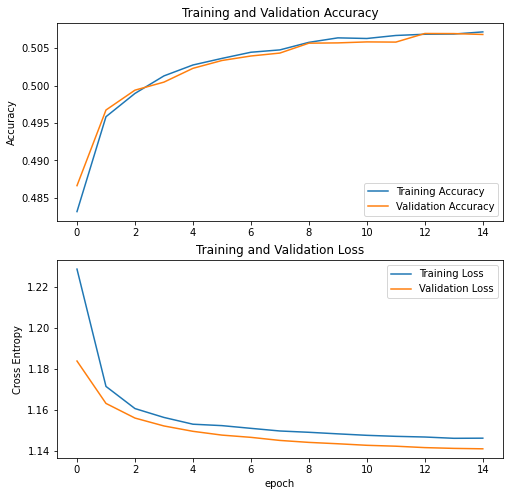

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()